In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import sys
import torch.optim as optim
from torchvision import models


In [ ]:
#define a transformation function for training and test
train_transformation = transforms.Compose([
    transforms.RandomResizedCrop(size=(32, 32), antialias=True),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

test_transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

#create training and test dataset
training = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transformation)
test = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transformation)

size_batch = 32
#create training and test loaders
train_loader = torch.utils.data.DataLoader(training, batch_size=size_batch,shuffle=True, num_workers=2,drop_last=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=1,shuffle=False, num_workers=2,drop_last=True)

#classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:06<00:00, 27990890.88it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


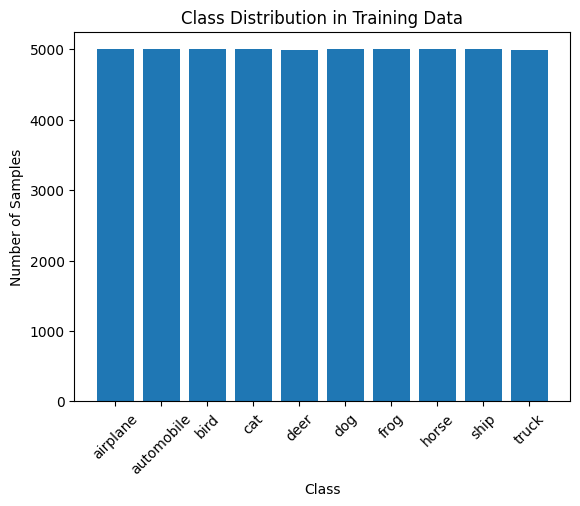

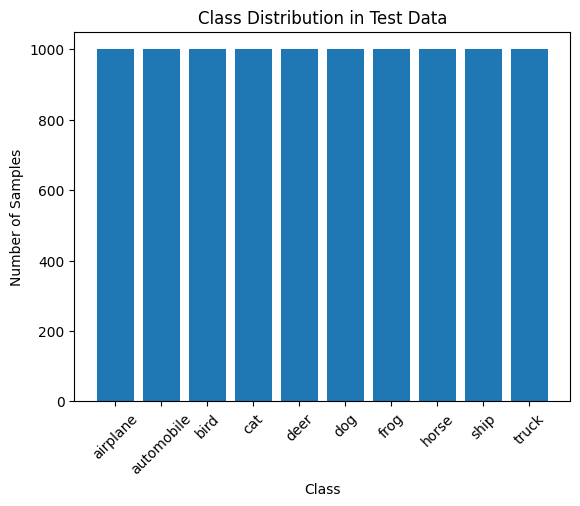

In [ ]:
def check_class_distribution(dataset, loader, name):
    classes = dataset.classes
    num_classes = len(classes)
    class_count = np.zeros(10)  #count occurrences of each class
    shape_image = None
    for images, labels in loader:
        if shape_image is None:
            shape_image = images[0].shape
        for label in labels:
            class_count[label] += 1
    plt.bar(classes, class_count)
    plt.title(f"Class Distribution in {name}")
    plt.xlabel("Class")
    plt.ylabel("Number of Samples")
    plt.xticks(rotation=45)  #better readability
    plt.show()
    return shape_image, num_classes


#distribution for training data
shape_image_train, num_classes_train = check_class_distribution(training,train_loader, "Training Data")
#distribution for test data
shape_image_test, num_classes_test = check_class_distribution(test, test_loader, "Test Data")

In [ ]:
#sanity check
if shape_image_train == shape_image_test:
  #input_size = torch.prod(torch.tensor(shape_image_train)).item()
  input_size = torch.tensor(shape_image_train)
if num_classes_train == num_classes_test:
  output_size = num_classes_train
print(input_size, output_size)
'''
print(int(input_size[0]))
print(int(input_size[1]))
print(int(input_size[2]))
'''

tensor([ 3, 32, 32]) 10


'\nprint(int(input_size[0]))\nprint(int(input_size[1]))\nprint(int(input_size[2]))\n'

In [ ]:
class Trial_CIFAR10(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(input_size[0],input_size[1] , kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(input_size[1])
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(input_size[1] ,input_size[1] , kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(input_size[1])
        self.fc1 = nn.Linear(input_size[1] * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, output_size)

    def forward(self, x):
        #print("1",x.shape)
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        #print("2",x.shape)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        #print("3",x.shape)
        # Flatten images into vectors
        x = x.view(x.size(0), -1)
        #print("4",x.shape)
        x = F.relu(self.fc1(x))
        #print("5",x.shape)
        x = F.relu(self.fc2(x))
        #print("6",x.shape)
        x = self.fc3(x)
        #print("7",x.shape)
        return x

In [ ]:
def get_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
device = get_device()
print(device)

cpu


In [ ]:
model = Trial_CIFAR10()
#model.load_state_dict(torch.load('/content/drive/MyDrive/Machine Intelligence Project/Project 2/trial_cifar10_50_noise.pth'))
model.load_state_dict(torch.load('/content/drive/MyDrive/Machine Intelligence Project/Project 2/trial_cifar10_50_noise_f_ep100.pth', map_location=torch.device('cpu')))

#model.load_state_dict(torch.load('/content/drive/MyDrive/Machine Intelligence Project/Project 2/trial_cifar10_100.pth'))
#model.eval()
model.to(device)
if next(model.parameters()).is_cuda:
    print("model moved to cuda")


In [ ]:
class DnCNN(nn.Module):
    def __init__(self, channels=3, num_of_layers=17):
        super(DnCNN, self).__init__()
        kernel_size = 3
        padding = 1
        features = 64
        layers = [nn.Conv2d(in_channels=channels, out_channels=features, kernel_size=kernel_size, padding=padding, bias=False),
                  nn.ReLU(inplace=True)]
        for _ in range(num_of_layers-2):
            layers.append(nn.Conv2d(features, features, kernel_size, padding=padding, bias=False))
            layers.append(nn.BatchNorm2d(features))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(features, channels, kernel_size, padding=padding, bias=False))
        self.dncnn = nn.Sequential(*layers)

    def forward(self, x):
        out = self.dncnn(x)
        return x - out


In [ ]:
# Noise
def adversarial_noise(images, epsilon=1):
    """Add random adversarial noise to the images."""
    noise = epsilon * torch.randn_like(images) #random noise
    noised_images = images + noise # adding noise
    return torch.clamp(noised_images, 0, 255) # making sure pixel values are valid

In [ ]:
# FGSM
def FGSM(model, image,labels,  epsilon=1):
    """
      The FGSM is an attack method designed to fool models by perturbing the input data slightly in a way that maximizes the loss.
      This function implements FGSM by taking a single image and its label, applying a gradient-based perturbation, and returning the modified image.
      The perturbation magnitude is controlled by `epsilon`, which determines how much to move along the gradient's sign direction.

    Parameters:
    - model : The neural network model which is being attacked.
    - image : A single image tensor for which the adversarial example is to be generated.
    - labels : The true labels associated with the image tensor.
    - epsilon : The perturbation magnitude used to create the adversarial image.

    Output:
    - perturbed_image : The image tensor after the FGSM attack, perturbed such that it aims to maximize the classification loss.
"""
    image = image.clone().detach().requires_grad_(True)

    outputs = model(image)
    #print(outputs.shape)
    criterion = nn.CrossEntropyLoss()
    loss = criterion(outputs, labels)
    model.zero_grad()
    loss.backward()
    image_grad = image.grad.data
    sign_image_grad = image_grad.sign()
    perturbed_image = image + epsilon * sign_image_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 255)

    return perturbed_image

In [ ]:
# PGD
def PGD(model, image,labels,  epsilon=50,alpha = 1, num_iter = 10):
    """
    The Projected Gradient Descent is an iterative method used to create adversarial examples by subtly and incrementally changing an image to maximize model error.
    This function handles the attack by taking a single image and its label, applying small, controlled changes, and ensuring these changes stay within a defined limit, epsilon.
    The amount adjusted per step is set by alpha, and the process repeats for a specified number of iterations to refine the adversarial effect.

    Parameters:
    - model : The neural network model which is being attacked.
    - image : A single image tensor for which the adversarial example is to be generated.
    - labels : The true labels associated with the image tensor.
    - epsilon : The perturbation magnitude used to create the adversarial image.
    - alpha : The step size for each iteration determining how much the image is modified at each step.
    - num-iter : The number of iterations to perform.

    Output:
    - perturbed_image : The image tensor after the PGD attack.
"""
    image.requires_grad = True
    criterion = nn.CrossEntropyLoss()
    for i in range(num_iter):
      outputs = model(image)
      loss = criterion(outputs, labels)
      model.zero_grad()
      loss.backward()
      image_grad = image.grad.data
      sign_image_grad = image_grad.sign()
      attacked_image = image + alpha * sign_image_grad
      dist = torch.clamp(attacked_image - image, -epsilon, epsilon)
      perturbed_image = torch.clamp(attacked_image - image, -epsilon, epsilon)
      perturbed_image = torch.clamp(perturbed_image, 0, 255)
    return perturbed_image

In [ ]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable


def deepfool(model, images, labels, target_labels, steps=50, epsilon=0.001):
    """
    Generate adversarial examples using the DeepFool algorithm for a batch of images.

    Args:
        model (torch.nn.Module): The PyTorch model to attack.
        images (torch.Tensor): Batch of input image tensors (assumes normalized to [0, 1]).
        labels (torch.Tensor): True labels of the images.
        target_labels (torch.Tensor): Target labels to misclassify to.
        steps (int): Number of iterations to find the minimal perturbation.
        epsilon (float): A small constant to avoid division by zero.

    Returns:
        torch.Tensor: Batch of adversarial image tensors.
    """
    # Move images and labels to device (CPU or GPU)
    device = next(model.parameters()).device
    images, labels, target_labels = images.to(device), labels.to(device), target_labels.to(device)

    # Convert images to require gradient computation
    #images = images.clone().detach().requires_grad_(True)
    #images = images.clone().requires_grad_(True)
    #images.requires_grad = True
    image_var = Variable(images.clone(), requires_grad=True)



    # Define optimizer
    #optimizer = torch.optim.Adam([images], lr=0.001)
    optimizer = torch.optim.Adam([image_var], lr=0.001)

    for just_d in range(steps):
        # Forward pass
        #outputs = model(images)
        outputs = model(image_var)

        # Calculate the loss
        loss = F.cross_entropy(outputs, target_labels)

        # Zero gradients, backward pass, and optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Retain gradients for computation
        #images.retain_grad()
        image_var.retain_grad()

        # Check if gradients are available
        #if images.grad is None:
        if image_var.grad is None:
            print("image grad is none", just_d)
            break

        # Compute the gradient of the loss w.r.t. the input images
        #gradients = images.grad
        #print('pases this once',just_d)
        gradients = image_var.grad

        # Compute the perturbation using the gradient sign
        perturbation = torch.sign(gradients)

        # Update the images with the perturbation
        #images = images + epsilon * perturbation
        #image_var = image_var + epsilon * perturbation
        image_var.data.add_(epsilon * perturbation)


        # Clip the perturbed images to the valid range [0, 1]
        #images = torch.clamp(images, 0, 1)
        #image_var = torch.clamp(image_var, 0, 1)
        image_var.data.clamp_(0, 1)


        # Check if target label reached for any image in the batch
        if torch.all(torch.eq(torch.argmax(outputs, dim=1), target_labels)):
            break

    # Return the batch of adversarial image tensors
    #return images
    return image_var


In [ ]:
def plot_images(image_tensor1,image_tensor2, l1,l2):
  import matplotlib.pyplot as plt
  import numpy as np


  # Transfer to CPU and convert to NumPy arrays
  image_array1 = image_tensor1.squeeze().cpu().detach().numpy()
  image_array2 = image_tensor2.squeeze().cpu().detach().numpy()

  # Transpose the array to match the order expected by matplotlib (H, W, C)
  image_np = np.transpose(image_array1, (1, 2, 0))
  c = (255*(image_np - np.min(image_np))/np.ptp(image_np)).astype(int)

  image_np2 = np.transpose(image_array2, (1, 2, 0))
  c2 = (255*(image_np2 - np.min(image_np2))/np.ptp(image_np2)).astype(int)


  # Plot the image
  #plt.imshow(c)
  #plt.axis('off')
  #plt.show()


  # Create subplots and display images

  #plt.figure(figsize=(10, 5))

  '''
  # Plot the first image
  plt.subplot(1, 3, 1)
  plt.imshow(c)
  plt.title('Image 1')
  plt.axis('off')

  # Plot the second image
  plt.subplot(1, 3, 2)
  plt.imshow(c2)
  plt.title('Image 2')
  plt.axis('off')

  plt.show()
  '''

  fig, axes = plt.subplots(1, 2, figsize=(8, 4))  # Create 1 row, 2 columns
  classes = {0:'plane', 1:'car', 2:'bird', 3:'cat',4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}

  axes[0].imshow(c)
  axes[1].imshow(c2)

  axes[0].set_title(f'Original_image: {classes[l1]}')
  axes[1].set_title(f'Deepfool_attacked: {classes[l2]}')

  fig.tight_layout()
  plt.savefig('trial_cifar10_noise_deepfool.png')
  plt.show()


In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable

def cw_attack(model, image, target_label, c=1, kappa=0, steps=1000, lr=0.01):
  """
  CW attack implementation in PyTorch.

  Args:
      model: PyTorch model to attack.
      image: Original image tensor (CHW format).
      target_label: Target label for the adversarial image.
      c: Parameter for the box-constraint (default: 1).
      kappa: Confidence parameter for the loss function (default: 0).
      steps: Number of optimization steps (default: 100).
      lr: Learning rate for the optimizer (default: 0.01).

  Returns:
      Adversarial image tensor.
  """
  # Convert image to PyTorch variable and detach gradients
  image_var = Variable(image.clone(), requires_grad=True)

  # Define optimizer
  optimizer = torch.optim.Adam([image_var], lr=lr)

  for step in range(steps):
    # Forward pass
    logits = model(image_var)
    target_logit = logits[0, target_label]
    other_logits = logits.max(dim=1)[0] - target_logit

    # Loss function
    #loss = torch.nn.functional.relu(other_logits - kappa) + c * torch.nn.functional.mse_loss(torch.tanh(image_var) + 1, image)
    relu_loss = torch.nn.functional.relu(other_logits - kappa).mean()
    mse_loss = c * torch.nn.functional.mse_loss(torch.tanh(image_var) + 1, image).mean()
    loss = relu_loss + mse_loss


    # Backward pass and update
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Clip image to valid range (0, 1)
    image_var.data.clamp_(0, 1)

  return image_var.data



In [ ]:
def FIA(model, image, target, epsilon=0.001, alpha=0.01, num_iter=50, drop_prob=0.3, ensemble_num=5):
    """
    Perform Feature Importance-aware Attack (FIA) considers the object-aware features that dominate the model decisions, using the aggregate
    gradient (gradients average concerning the feature maps). This approach avoids local optimum, represents transferable feature importance,
    and uses the aggregate gradient to assign weights identifying the essential features. Furthermore, FIA generates highly transferable
    adversarial examples when extracting the feature importance from multiple classification models.

    Parameters:
    - model: the neural network model (PyTorch model).
    - image: input image tensor
    - target: true label of the image.
    - epsilon: maximum perturbation.
    - alpha: step size for each iteration.
    - num_iter: number of iterations.
    - drop_prob: probability of dropping a pixel.
    - ensemble_num: number of random masks used to compute aggregate gradient.

    Returns:
    - perturbed_image: adversarially perturbed image.
    """
    # Ensuring computation is in evaluation mode to deactivate dropout layers
    #model.eval()

    # Initializing perturbation to zero
    perturbation = torch.zeros_like(image)

    # Looping over the number of iterations
    for _ in range(num_iter):
        # Initializing aggregate gradients to zero
        aggregate_gradients = torch.zeros_like(image)

        # Generating multiple masked versions of the image
        for _ in range(ensemble_num):
            # Applying random pixel dropping
            mask = (torch.rand_like(image) > drop_prob).float()
            masked_image = image * mask
            masked_image.requires_grad = True

            # Forward pass
            output = model(masked_image)
            loss = nn.CrossEntropyLoss()(output, target)

            # Zero all existing gradients
            model.zero_grad()

            # Calculating gradients of model in backward pass
            loss.backward()

            # Accumulating the gradients
            aggregate_gradients += masked_image.grad.data

        # Averaging the gradients over all masked versions
        aggregate_gradients /= ensemble_num

        # Sign of the aggregated gradients
        grad_sign = aggregate_gradients.sign()

        # Updating the perturbation by a small step in the opposite direction of the gradient
        perturbation += alpha * grad_sign
        perturbation = torch.clamp(perturbation, -epsilon, epsilon)

    # Apply the perturbation to the original image and clip to maintain valid pixel range
    perturbed_image = image + perturbation
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    return perturbed_image


In [ ]:
#JSM
def JSM(model, image, labels, max_iters = 100, threshold=0.1):
    """
    Jacobian-based Saliency Maps (JSM) explore the forward derivates to calculate the model gradients, replacing the
    gradient descent approaches, and discover which input regions are likely to yield adversarial examples.
    Then it uses saliency maps to construct the adversarial saliency maps, which display the features the adversary must perturb.

    Parameters:
    - model : The neural network model which is being attacked.
    - image : A single image tensor for which the adversarial example is to be generated.
    - max_iters (int): Maximum number of iterations for the attack.
    - labels : The true labels associated with the image tensor.
    - threshold (float): Threshold for pixel perturbation.

    Output:
    - perturbed_image : The image tensor after the JSM attack.
    """
    model.eval()
    image.requires_grad = True
    batch_size = image.size(0)

    for _ in range(max_iters):
        output = model(image)
        loss = F.cross_entropy(output,labels)
        model.zero_grad()
        loss.backward()

        saliency_map = image.grad.abs().sum(dim=1)
        perturb_mask = saliency_map > threshold
        perturb_values = torch.sign(image.grad) * perturb_mask.float().unsqueeze(1)
        image.data +=perturb_values
        image.grad.data.zero_()

    image = torch.clamp(image,0,1)
    return image


In [ ]:
dncnn = DnCNN(channels=3)  # Assuming the model expects 3-channel inputs
dncnn.to(device)
if next(dncnn.parameters()).is_cuda:
    print("model moved to cuda")

dncnn.load_state_dict(torch.load('/content/drive/MyDrive/Machine Intelligence Project/Project 2/dncnn_model.pth', map_location=torch.device('cpu')))
dncnn.eval()  # Set the model to evaluation mode

def adversarial_examples(model, dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    total_correct_orig = 0
    total_correct_noisy = 0
    total_correct_fgsm = 0
    total_correct_pgd = 0
    total_correct_Fia = 0
    total_correct_deepfool = 0
    total_correct_JSM = 0
    total_correct_cw = 0
    total_samples = 0  # Track the total number of samples processed

    for images, labels in dataloader:
        batch_size = images.size(0)  # Get the actual size of the batch
        images, labels = images.to(device), labels.to(device)

        target_label = (labels + 1) % output_size
        target_label = target_label.to(device)

        # Generate adversarial examples (placeholder functions)
        adv_images = adversarial_noise(images)
        #print(labels.shape)
        #print(images.shape)
        adv_images2 = FGSM(model, images, labels)
        adv_images3 = PGD(model, images,labels)
        #adv_images4 = FIA(model, images,target_label)
        #adv_images5 = cw_attack(model, images,target_label)
        #adv_images6 = deepfool(model, images,labels,target_label)
        #adv_images7 = JSM(model, images,labels)

        # Denoising using DnCNN (assuming dncnn is defined and loaded)
        denoised_images = dncnn(adv_images)
        denoised_images2 = dncnn(adv_images2)
        denoised_images3 = dncnn(adv_images3)
        #denoised_images4 = dncnn(adv_images4)
        #denoised_images5 = dncnn(adv_images5)
        #denoised_images6 = dncnn(adv_images6)
        #denoised_images7 = dncnn(adv_images7)


        # Evaluate the model on both original and denoised images
        outputs_orig = model(images)
        outputs_adv = model(denoised_images)
        outputs_adv2 = model(denoised_images2)
        outputs_adv3 = model(denoised_images3)
        #outputs_adv4 = model(denoised_images4)
        #outputs_adv5 = model(denoised_images5)
        #outputs_adv6 = model(denoised_images6)
        #outputs_adv7 = model(denoised_images7)


        # Compute accuracy
        _, predicted_orig = torch.max(outputs_orig.data, 1)
        _, predicted1 = torch.max(outputs_adv.data, 1)
        _, predicted2 = torch.max(outputs_adv2.data, 1)
        _, predicted3 = torch.max(outputs_adv3.data, 1)
        #_, predicted4 = torch.max(outputs_adv4.data, 1)
        #_, predicted5 = torch.max(outputs_adv5.data, 1)
        #_, predicted6 = torch.max(outputs_adv6.data, 1)
        #_, predicted7 = torch.max(outputs_adv7.data, 1)


        total_correct_orig += torch.eq(predicted_orig, labels).sum().item()
        total_correct_noisy += torch.eq(predicted1, labels).sum().item()
        total_correct_fgsm += torch.eq(predicted2, labels).sum().item()
        total_correct_pgd += torch.eq(predicted3, labels).sum().item()
        #total_correct_FIA += torch.eq(predicted4, labels).sum().item()
        #total_correct_cw += torch.eq(predicted5, labels).sum().item()
        #total_correct_deepfool += torch.eq(predicted6, labels).sum().item()
        #total_correct_JSM += torch.eq(predicted7, labels).sum().item()
        total_samples += batch_size  # Update total samples processed

    # Print overall accuracy
    print("Overall Original Accuracy:", total_correct_orig / total_samples)
    print("Overall Accuracy on Noisy Images:", total_correct_noisy / total_samples)
    print("Overall Accuracy on FGSM Images:", total_correct_fgsm / total_samples)
    print("Overall Accuracy on PGD Images:", total_correct_pgd / total_samples)
    #print("Overall Accuracy on FIA Images:", total_correct_FIA / total_samples)
    #print("Overall Accuracy on CW Images:", total_correct_cw / total_samples)
    #print("Overall Accuracy on deepfool Images:", total_correct_deepfool / total_samples)
    #print("Overall Accuracy on JSM Images:", total_correct_JSM / total_samples)

adversarial_examples(model, test_loader)

Overall Original Accuracy: 0.3614
Overall Accuracy on Noisy Images: 0.2992
Overall Accuracy on FGSM Images: 0.0126
Overall Accuracy on PGD Images: 0.0095


In [ ]:
def adversarial_examples(model, dataloader):
    """Testing the model with adversarial examples and print loss values."""
    image_tensor1,image_tensor2, image_tensor3 = None, None, None
    l1, l2 = 9998, 9999
    batch_id = 99999
    for batch_idx, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device)
        image_tensor1 = images


        # adversarial examples
        #adv_images = adversarial_noise(images)
        #adv_images2 = FGSM(model,images)
        #adv_images3 = PGD(model,images)
        target_label = (labels + 1) % output_size
        target_label = target_label.to(device)
        #adv_image_cw = cw_attack(model, images, target_label)


        adv_image_df = deepfool(model, images, labels, target_label)
        print(adv_image_df.shape)
        image_tensor2 = adv_image_df

        # original and attacked output label
        outputs_orig = model(images)
        _, predicted_orig = torch.max(outputs_orig.data, 1)
        correct_predictions_orig = torch.eq(predicted_orig, labels).sum().item()


        #outputs_adv = model(adv_images)
        #outputs_adv2 = model(adv_images2)
        #outputs_adv3 = model(adv_images3)
        #outputs_cw = model(adv_image_cw)
        outputs_df = model(adv_image_df)

        # loss
        loss_orig = F.cross_entropy(outputs_orig, labels)
        #loss_adv = F.cross_entropy(outputs_adv, labels)
        #loss_adv2 = F.cross_entropy(outputs_adv2, labels)
        #loss_adv3 = F.cross_entropy(outputs_adv3, labels)
        #loss_cw =  F.cross_entropy(outputs_cw, labels)
        loss_df =  F.cross_entropy(outputs_df, labels)
        l1 = labels.cpu().numpy()[0]
        _, predicted = torch.max(outputs_df.data, 1)
        correct_predictions = torch.eq(predicted, labels).sum().item()
        l2 = predicted.cpu().numpy()[0]

        if l1 == l2:

          # labels and loss values
          print("Original labels: ", labels.cpu().numpy())

          print("Loss on original images: ", loss_orig.item())
          #print("Loss on noisy adversarial images: ", loss_adv.item())
          #print("Loss on FGSM images: ", loss_adv2.item())
          #print("Loss on FGSM images: ", loss_adv3.item())
          #_, predicted = torch.max(outputs_cw.data, 1)


          print("target label", target_label.cpu().numpy())
          print(f"Predicted Label for Adversarial Image: {predicted.cpu().numpy()}")
          #print("loss on cw", loss_cw)
          print("loss on df", loss_df)
          print("batch_idx", batch_idx)
          batch_id = batch_idx
          break

    #accuracy_orig = correct_predictions_orig / len(labels)
    #print(f"Accuracy: {accuracy_orig}")
    #accuracy = correct_predictions / len(labels)
    #print(f"Accuracy: {accuracy}")
    plot_images(image_tensor1,image_tensor2, l1, l2)
    return batch_id



torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])
Original labels:  [8]
Loss on original images:  2.0497429370880127
target label [9]
Predicted Label for Adversarial Image: [8]
loss on df tensor(1.0962, device='cuda:0', grad_fn=<NllLossBackward0>)
batch_idx 1


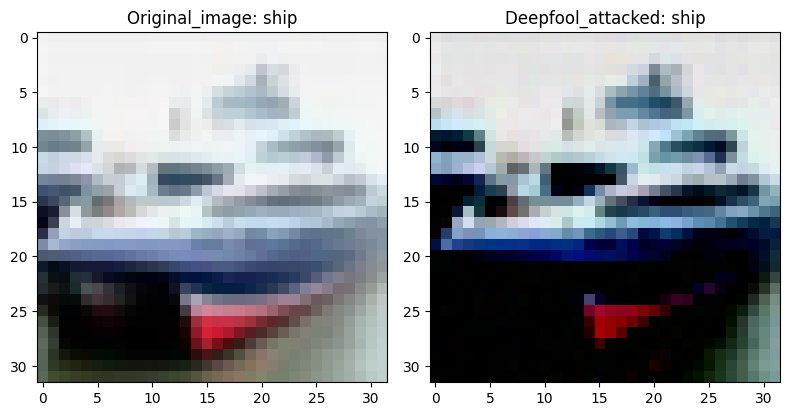

In [ ]:
batch_id = adversarial_examples(model, test_loader)

In [ ]:
#batch_id = 1

In [ ]:
model = Trial_CIFAR10()
#model.load_state_dict(torch.load('/content/drive/MyDrive/Machine Intelligence Project/Project 2/trial_cifar10_50_noise.pth'))
model.load_state_dict(torch.load('/content/drive/MyDrive/Machine Intelligence Project/Project 2/trial_cifar10_100.pth'))
#model.eval()
model.to(device)
if next(model.parameters()).is_cuda:
    print("model moved to cuda")


model moved to cuda


In [ ]:
def adversarial_examples_match(model, dataloader, batch_id):
    """Testing the model with adversarial examples and print loss values."""
    image_tensor1,image_tensor2, image_tensor3 = None, None, None
    l1, l2 = 9998, 9999
    for batch_idx, (images, labels) in enumerate(dataloader):
      if batch_idx == batch_id:
          images, labels = images.to(device), labels.to(device)
          image_tensor1 = images


          # adversarial examples
          #adv_images = adversarial_noise(images)
          #adv_images2 = FGSM(model,images)
          #adv_images3 = PGD(model,images)
          target_label = (labels + 1) % output_size
          target_label = target_label.to(device)
          #adv_image_cw = cw_attack(model, images, target_label)


          adv_image_df = deepfool(model, images, labels, target_label)
          print(adv_image_df.shape)
          image_tensor2 = adv_image_df

          # original and attacked output label
          outputs_orig = model(images)
          _, predicted_orig = torch.max(outputs_orig.data, 1)
          correct_predictions_orig = torch.eq(predicted_orig, labels).sum().item()


          #outputs_adv = model(adv_images)
          #outputs_adv2 = model(adv_images2)
          #outputs_adv3 = model(adv_images3)
          #outputs_cw = model(adv_image_cw)
          outputs_df = model(adv_image_df)

          # loss
          loss_orig = F.cross_entropy(outputs_orig, labels)
          #loss_adv = F.cross_entropy(outputs_adv, labels)
          #loss_adv2 = F.cross_entropy(outputs_adv2, labels)
          #loss_adv3 = F.cross_entropy(outputs_adv3, labels)
          #loss_cw =  F.cross_entropy(outputs_cw, labels)
          loss_df =  F.cross_entropy(outputs_df, labels)
          l1 = labels.cpu().numpy()[0]
          _, predicted = torch.max(outputs_df.data, 1)
          correct_predictions = torch.eq(predicted, labels).sum().item()
          l2 = predicted.cpu().numpy()[0]

          #if l1 == l2:

          # labels and loss values
          print("Original labels: ", labels.cpu().numpy())

          print("Loss on original images: ", loss_orig.item())
          #print("Loss on noisy adversarial images: ", loss_adv.item())
          #print("Loss on FGSM images: ", loss_adv2.item())
          #print("Loss on FGSM images: ", loss_adv3.item())
          #_, predicted = torch.max(outputs_cw.data, 1)


          print("target label", target_label.cpu().numpy())
          print(f"Predicted Label for Adversarial Image: {predicted.cpu().numpy()}")
          #print("loss on cw", loss_cw)
          print("loss on df", loss_df)
          print("batch_idx", batch_idx)
          break

    #accuracy_orig = correct_predictions_orig / len(labels)
    #print(f"Accuracy: {accuracy_orig}")
    #accuracy = correct_predictions / len(labels)
    #print(f"Accuracy: {accuracy}")
    plot_images(image_tensor1,image_tensor2, l1, l2)



torch.Size([1, 3, 32, 32])
Original labels:  [8]
Loss on original images:  2.5521187782287598
target label [9]
Predicted Label for Adversarial Image: [0]
loss on df tensor(2.1159, device='cuda:0', grad_fn=<NllLossBackward0>)
batch_idx 1


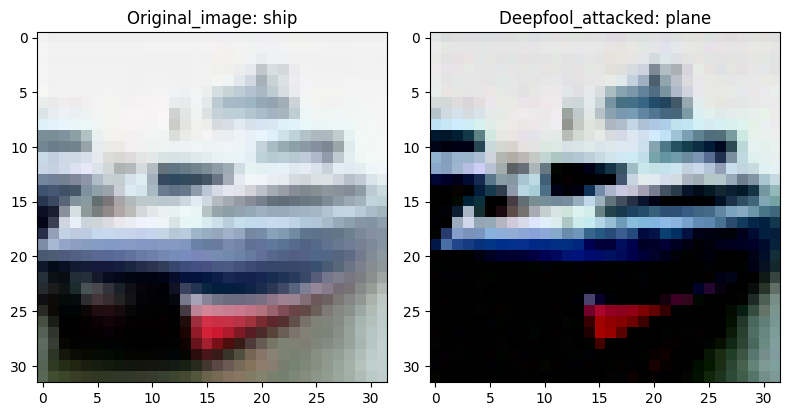

In [ ]:
adversarial_examples_match(model, test_loader, batch_id)